# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
import numpy as np

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [6]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [7]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [8]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain']=gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [9]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [10]:
from sklearn import metrics

dtree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)
y_pred=tree_predict(X_test, dtree)

print('Desition Tree F1 score:',round(metrics.f1_score(y_pred, y_test),4),
'\nDesition Tree accuracy score:',round(metrics.accuracy_score(y_pred, y_test),4))

Desition Tree F1 score: 0.8993 
Desition Tree accuracy score: 0.8772


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [11]:
import numpy as np

#Número de árboles
n_estimators = 10

# Semilla
np.random.seed(123)

# Ejemplos de muestra
n_samples = X_train.shape[0]

# Crear el muestreo aleatorio(will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [12]:
# Crear los árboles
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]],
                                               level=0, min_gain=0.001, max_depth=9, num_pct=10))

y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [13]:
print('Desition Tree F1 score:',round(metrics.f1_score(y_pred, y_test),4),
'\nDesition Tree accuracy score:',round(metrics.accuracy_score(y_pred, y_test),4))

Desition Tree F1 score: 0.8989 
Desition Tree accuracy score: 0.8779


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [177]:
def best_split_mf(X, y, num_pct=10,max_features=X.shape[1]):
   
    X_ = X.sample(max_features, axis=1)
    
    features = range(X_.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X_.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X_.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
            
    col = X_.columns[best_split[0]]
    best_split[0] = X.columns.get_loc(col)
    
    return best_split

In [178]:
def tree_grow_mf(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=X.shape[1]):

    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split_mf(X, y, num_pct,max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain']=gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow_mf(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth,
                              num_pct=num_pct, max_features=max_features)
    
    tree['sr'] = tree_grow_mf(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth,
                              num_pct=num_pct, max_features=max_features)
    
    return tree

In [232]:
dtree = tree_grow_mf(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10, max_features=5)
y_pred=tree_predict(X_test, dtree)

print('Desition Tree F1 score:',round(metrics.f1_score(y_pred, y_test),4),
'\nDesition Tree accuracy score:',round(metrics.accuracy_score(y_pred, y_test),4))

Desition Tree F1 score: 0.8997 
Desition Tree accuracy score: 0.8793


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [280]:
# Crear los árboles
import math
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
max=round(math.log(X_test.shape[1]))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, tree_grow_mf(X_train, y_train, level=0,min_gain=0.001,max_depth=i+5,
                                                            num_pct=10, max_features=int(max)))

y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [281]:
print('Desition Tree F1 score:',round(metrics.f1_score(y_pred, y_test),4),
'\nDesition Tree accuracy score:',round(metrics.accuracy_score(y_pred, y_test),4))

Desition Tree F1 score: 0.8891 
Desition Tree accuracy score: 0.8604


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [294]:
from sklearn.ensemble import RandomForestClassifier

RFC=RandomForestClassifier(n_estimators=100, max_features=5, random_state=123, max_depth=6, n_jobs=-1).fit(X_train,y_train)
y_pred=RFC.predict(X_test)
print('Desition Tree F1 score:',round(metrics.f1_score(y_pred, y_test),4),
'\nDesition Tree accuracy score:',round(metrics.accuracy_score(y_pred, y_test),4))

Desition Tree F1 score: 0.902 
Desition Tree accuracy score: 0.8818


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

# Max_depth

Text(0,0.5,'Accuracy')

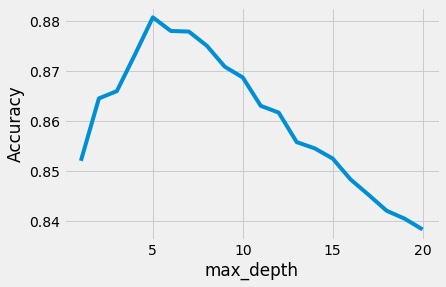

In [299]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import cross_val_score

# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [300]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8807010777000237, 5)

# Max_features

Text(0,0.5,'Accuracy')

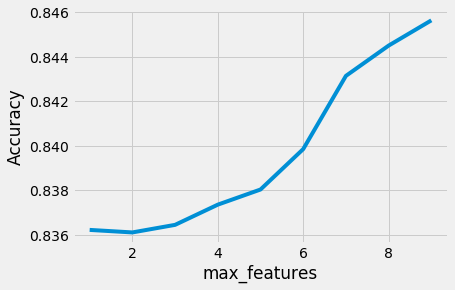

In [310]:
# list of values to try for max_features
feature_range = range(1, X_train.shape[1]+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [311]:
sorted(zip(accuracy_scores, feature_range))[::-1][0]

(0.8456295396520653, 9)

# n_estimators

Text(0,0.5,'Accuracy')

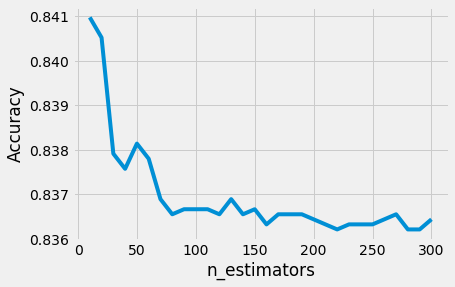

In [307]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [306]:
sorted(zip(accuracy_scores, estimator_range))[::-1][0]

(0.840977797413607, 10)

In [328]:
# acc=0
# for i in range(1,100):
RFC=RandomForestClassifier(n_estimators=10, max_features=9, random_state=71, max_depth=5, n_jobs=-1).fit(X_train,y_train)
y_pred=RFC.predict(X_test)
#     if acc<metrics.accuracy_score(y_pred, y_test):
#         acc=metrics.accuracy_score(y_pred, y_test)
#         rs=i
        
print('Desition Tree F1 score:',round(metrics.f1_score(y_pred, y_test),4),#'rs:',rs,
'\nDesition Tree accuracy score:',round(metrics.accuracy_score(y_pred, y_test),4))

Desition Tree F1 score: 0.9046 
Desition Tree accuracy score: 0.8853
